In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.append('../')
from utilities import *

sys.path.append('../lib')
from vae_2d import *
from Koopman_2d import *
# from fno_2d import *
from rnn_base import *

from timeit import default_timer
import scipy.io
import os
import matplotlib.pyplot as plt
import tqdm as tqdm

torch.manual_seed(0)
np.random.seed(0)

In [2]:
# Load Kuramoto-Sivashinsky data
ks_data = np.load('../data/KS_test_data.npy')
print(f"KS data shape: {ks_data.shape}")  # Should be (1200, 2000, 512)

KS data shape: (120, 2000, 512)


In [3]:
T_in = 200  # skip first 100 timesteps
T = 1600    # seconds to extract from each trajectory
T_out = T_in + T
step = 1    # Seconds to learn solution operator
batch_size = 400
steps_per_sec = 10  # given temporal subsampling

in_dim = 512   # KS data has 512 dimensions
out_dim = 512

# experiment parameters
epochs = 100 # 1000
learning_rate = 0.0001# 0.0005
scheduler_step = 10
scheduler_gamma = 0.5

gamma_1 = 1
latent_dim = 4 # origin 10

In [74]:
# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the trained model
model_path = '/home/di49mer/qcbm/model/KS_model_with_qcbm/model_2.pt'
model_qcbm = torch.load(model_path, map_location=device,weights_only=False)
model_qcbm.eval()
print("Model with qcbm loaded successfully")

# Load the trained model
model_path = '/home/di49mer/qcbm/model/KS_model_without_qcbm&id/model.pt'
model_noqcbm = torch.load(model_path, map_location=device,weights_only=False)
model_noqcbm.eval()
print("Model without qcbm loaded successfully")

# Load KS test data
ks_data = np.load('../data/KS_test_data.npy')
print(f"KS data shape: {ks_data.shape}")  # Should be (120, 2000, 512)

# Extract first trajectory
first_trajectory = ks_data[2]  # Shape: (2000, 512)
print(f"First trajectory shape: {first_trajectory.shape}")

# Convert to torch tensor
first_trajectory = torch.tensor(first_trajectory, dtype=torch.float32)

# Parameters (should match your training parameters)
T_in = 200  # skip first timesteps
T_pred = 500  # number of steps to predict
out_dim = 512  # KS data has 512 dimensions

Using device: cpu
Model with qcbm loaded successfully
Model without qcbm loaded successfully
KS data shape: (120, 2000, 512)
First trajectory shape: (2000, 512)


In [75]:


def evaluate_trajectory(model, trajectory, T_in, T_pred, device):
    """
    Evaluate the model on a single trajectory using autoregressive prediction.
    
    Args:
        model: Trained model
        trajectory: Input trajectory tensor of shape (time_steps, spatial_dim)
        T_in: Number of initial timesteps to skip
        T_pred: Number of timesteps to predict
        device: Device to run on
    
    Returns:
        predictions: Predicted trajectory
        ground_truth: Actual trajectory for comparison
    """
    model.eval()
    
    # Get initial condition and ground truth
    initial_state = trajectory[T_in-1:T_in].to(device)  # Shape: (1, 512)
    ground_truth = trajectory[T_in:T_in+T_pred]  # Shape: (T_pred, 512)
    
    predictions = []
    current_state = initial_state.view(-1, out_dim)  # Reshape for model input
    
    with torch.no_grad():
        for step in range(T_pred):
            # Get prediction from model
            pred, _ = model(current_state, mode='forward')
            pred = pred[0].reshape(-1, out_dim)
            
            # Store prediction
            predictions.append(pred.cpu())
            
            # Use prediction as input for next step (autoregressive)
            current_state = pred
    
    # Convert predictions to tensor
    predictions = torch.cat(predictions, dim=0)  # Shape: (T_pred, 512)
    
    return predictions, ground_truth

# Evaluate the model
print("Starting evaluation...")
predictions, ground_truth = evaluate_trajectory(model_qcbm, first_trajectory, T_in, T_pred, device)
predictions2, ground_truth = evaluate_trajectory(model_noqcbm, first_trajectory, T_in, T_pred, device)
print(f"Predictions shape: {predictions.shape}")
print(f"Ground truth shape: {ground_truth.shape}")

# Calculate metrics
def calculate_metrics(pred, truth):
    """Calculate various error metrics"""
    mse = torch.mean((pred - truth) ** 2)
    rmse = torch.sqrt(mse)
    mae = torch.mean(torch.abs(pred - truth))
    
    # Relative error
    truth_norm = torch.norm(truth)
    rel_error = torch.norm(pred - truth) / truth_norm
    
    return {
        'MSE': mse.item(),
        'RMSE': rmse.item(), 
        'MAE': mae.item(),
        'Relative Error': rel_error.item()
    }

metrics = calculate_metrics(predictions, ground_truth)
print("\nEvaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.6f}")

# Visualization functions
def plot_trajectory_comparison(pred, truth, n_points=5):
    """Plot comparison at specific spatial points"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    # Select spatial points to visualize
    spatial_points = np.linspace(0, pred.shape[1]-1, n_points, dtype=int)
    
    for i, point in enumerate(spatial_points):
        if i < len(axes):
            axes[i].plot(truth[:, point], 'b-', label='Ground Truth', linewidth=2)
            axes[i].plot(pred[:, point], 'r--', label='Prediction', linewidth=2)
            axes[i].set_title(f'Spatial Point {point}')
            axes[i].set_xlabel('Time Step')
            axes[i].set_ylabel('Value')
            axes[i].legend()
            axes[i].grid(True)
    
    # Remove empty subplot
    if len(spatial_points) < len(axes):
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.suptitle('Trajectory Comparison at Different Spatial Points', y=1.02)
    plt.show()

def plot_spatiotemporal_comparison(pred, truth, title_suffix=""):
    """Plot spatiotemporal evolution"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Ground truth
    im1 = axes[0].imshow(truth.T, aspect='auto', cmap='viridis', origin='lower',vmin=-3,vmax=3)
    axes[0].set_title('Ground Truth')
    axes[0].set_xlabel('Time Step')
    axes[0].set_ylabel('Spatial Dimension')
    plt.colorbar(im1, ax=axes[0])
    
    # Prediction
    im2 = axes[1].imshow(pred.T, aspect='auto', cmap='viridis', origin='lower',vmin=-3,vmax=3)
    axes[1].set_title('Prediction')
    axes[1].set_xlabel('Time Step')
    axes[1].set_ylabel('Spatial Dimension')
    plt.colorbar(im2, ax=axes[1])
    
    # Error
    error = torch.abs(pred - truth)
    im3 = axes[2].imshow(error.T, aspect='auto', cmap='Reds', origin='lower',vmin=0,vmax=6)
    axes[2].set_title('Absolute Error')
    axes[2].set_xlabel('Time Step')
    axes[2].set_ylabel('Spatial Dimension')
    plt.colorbar(im3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

def plot_error_evolution(pred, truth):
    """Plot how error evolves over time"""
    # Calculate error at each timestep
    mse_per_step = torch.mean((pred - truth) ** 2, dim=1)
    mae_per_step = torch.mean(torch.abs(pred - truth), dim=1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(mse_per_step, 'b-', linewidth=2)
    ax1.set_title('MSE Evolution')
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('MSE')
    ax1.grid(True)
    
    ax2.plot(mae_per_step, 'r-', linewidth=2)
    ax2.set_title('MAE Evolution')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('MAE')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()



Starting evaluation...
Predictions shape: torch.Size([500, 512])
Ground truth shape: torch.Size([500, 512])

Evaluation Metrics:
MSE: 3.227880
RMSE: 1.796630
MAE: 1.407016
Relative Error: 1.386250



Generating visualizations...


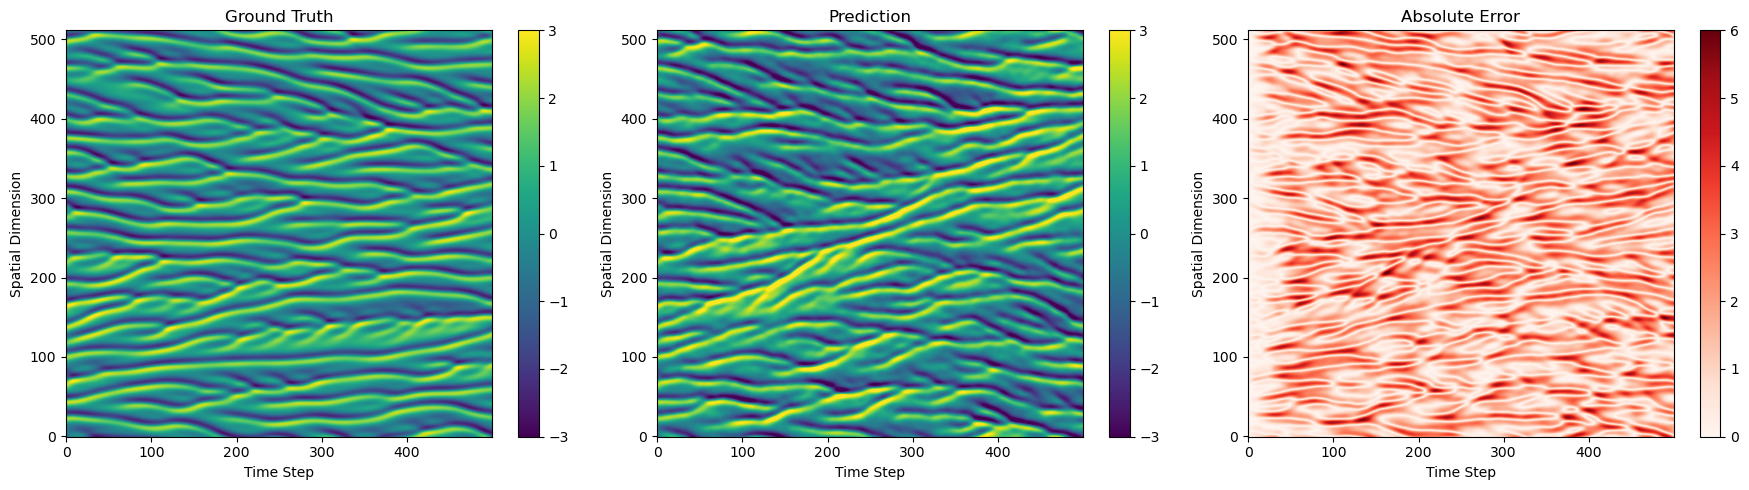

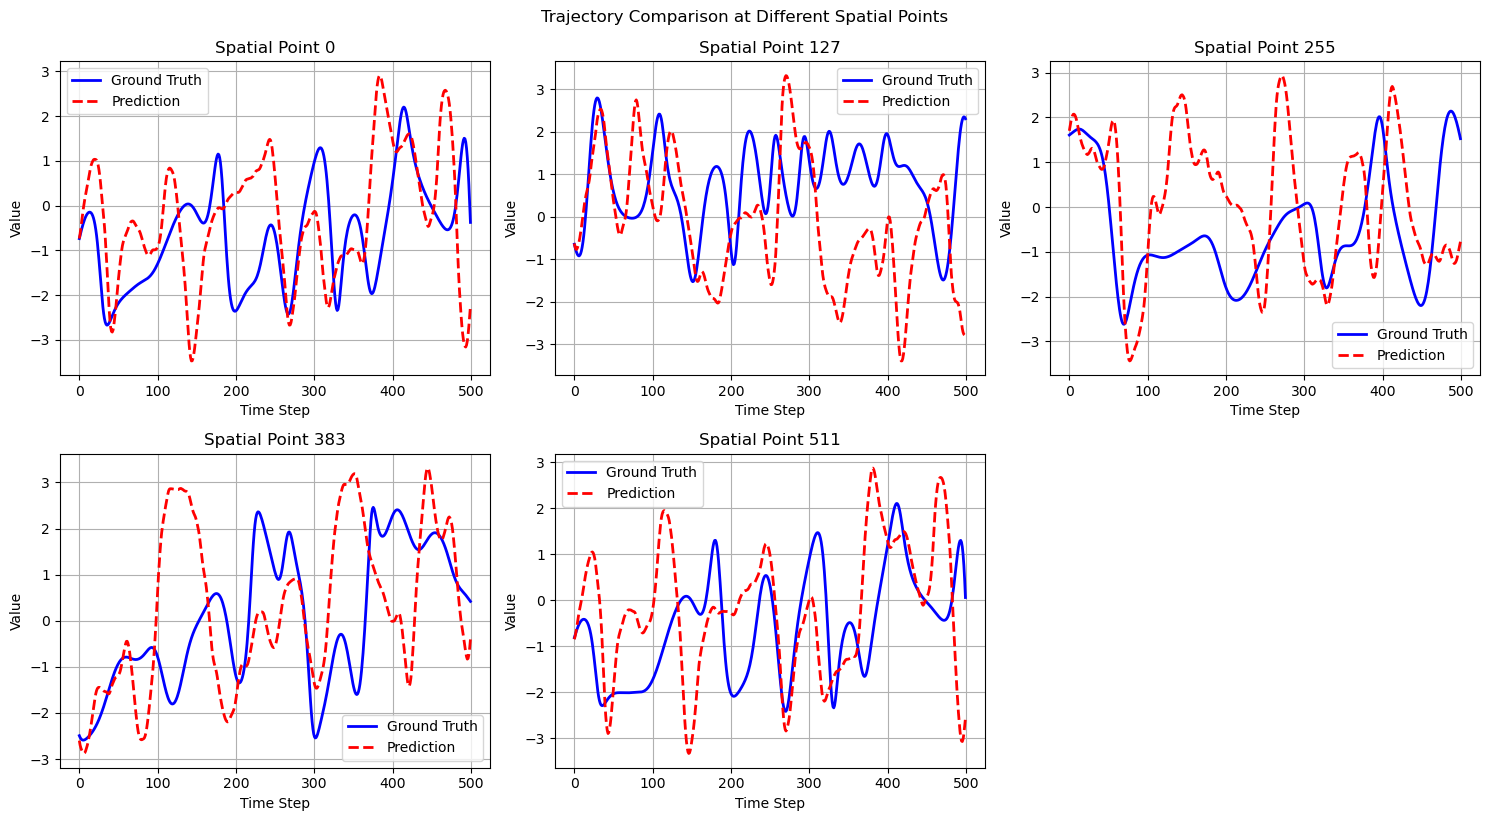

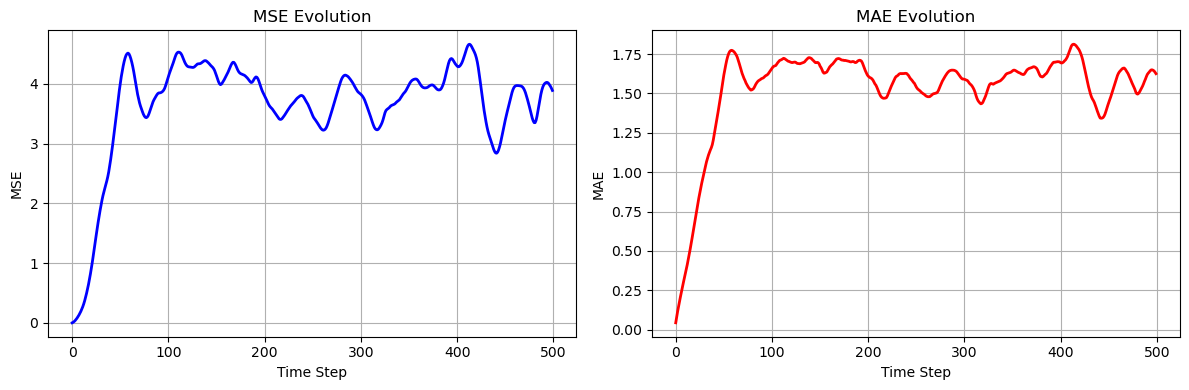

Evaluation complete!


In [29]:
# Create visualizations
print("\nGenerating visualizations...")
# 1. Spatiotemporal comparison
plot_spatiotemporal_comparison(predictions, ground_truth)

# 2. Trajectory comparison at specific points
plot_trajectory_comparison(predictions, ground_truth)

# 3. Error evolution
plot_error_evolution(predictions, ground_truth)

# Optional: Save results
save_results = False  # Set to True if you want to save
if save_results:
    results = {
        'predictions': predictions.numpy(),
        'ground_truth': ground_truth.numpy(),
        'metrics': metrics
    }
    np.save('evaluation_results.npy', results)
    print("Results saved to evaluation_results.npy")

print("Evaluation complete!")

Customize the model path before load

In [ ]:
#spectrum; distrbution; prediction; error;